In [24]:
#Import modules
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import time
from statsmodels.tsa.stattools import adfuller
from tqdm import tqdm
from PIL import Image
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tools.sm_exceptions import ConvergenceWarning
from datetime import datetime
import pickle
import warnings
from numpy import linalg as LA
warnings.filterwarnings('ignore')

try:
    import cust_f
except:
    pass
# to perform multiprocessing using a customized function (not necessary for Linux)

tot_run_time_start = time.time()

In [2]:
plt.style.use('default')

mpl.rcParams['axes.unicode_minus'] = False

# Matplotlib fontsize change
SMALL_SIZE = 15
MEDIUM_SIZE = 20
LARGE_SIZE = 25

plt.rc('font', size=SMALL_SIZE, weight='bold')
plt.rc('axes', titlesize=LARGE_SIZE, titleweight='bold')
plt.rc('axes', labelsize=MEDIUM_SIZE, labelweight='bold')
plt.rc('axes', titleweight='bold')
plt.rc('xtick', labelsize=LARGE_SIZE)
plt.rc('ytick', labelsize=MEDIUM_SIZE)
plt.rc('legend', fontsize=SMALL_SIZE)
plt.rc('figure', titlesize=LARGE_SIZE)

# Save figure settings
high_dpi = 300
fig_file_ext = '.png'
Image.MAX_IMAGE_PIXELS = None  # Ignore DecompressionBombError

In [11]:
with open("../btc_usd_1d.pkl", "rb") as f:
    df = pickle.load(f)
    df.rename(inplace=True, columns={'o': 'Open', 'h': 'High', 'l':'Low', 'c': 'Close', 'v': 'Volume'})
    df.index.name = 'Datetime'
    df['Datetime'] = df.index

In [4]:
df

,Open,High,Low,Close,Volume,Datetime
Datetime,,,,,,
2017-01-01,966.34,1005.00,960.53,998.80,6.579904e+06,2017-01-01
2017-01-02,997.75,1032.00,990.01,1014.10,8.190255e+06,2017-01-02
2017-01-03,1011.44,1039.00,999.99,1036.99,8.955193e+06,2017-01-03
2017-01-04,1035.51,1139.89,1028.56,1122.56,2.325716e+07,2017-01-04
2017-01-05,1114.38,1136.72,885.41,994.02,3.503690e+07,2017-01-05
...,...,...,...,...,...,...
2022-05-12,29077.90,30257.00,26631.00,29020.70,9.644756e+05,2022-05-12
2022-05-13,29020.80,31072.60,28730.40,29274.30,5.076201e+05,2022-05-13
2022-05-14,29274.20,30352.20,28602.30,30079.80,3.157569e+05,2022-05-14


In [5]:
y = df['Close']
y_1diff = df['Close'].diff().dropna()
result = adfuller(y)
print(f'원 데이터 ADF Statistic: {result[0]:.3f}')
print(f'원 데이터 p-value: {result[1]:.3f}')
result = adfuller(y_1diff)
print(f'1차 차분 ADF Statistic: {result[0]:.3f}')
print(f'1차 차분 p-value: {result[1]:.3f}')

원 데이터 ADF Statistic: -1.344
원 데이터 p-value: 0.609
1차 차분 ADF Statistic: -7.455
1차 차분 p-value: 0.000


In [3]:
def backtest_ma(test_df):
    df = test_df.copy()
    df['ma5'] = df['Open'].rolling(window=5).mean()
    df['ma10'] = df['Open'].rolling(window=10).mean()
    df['ma20'] = df['Open'].rolling(window=20).mean()
    df['ma50'] = df['Open'].rolling(window=50).mean()
    df['ma100'] = df['Open'].rolling(window=100).mean()

    df['rate'] = 0
    df['rate'] = np.where(df['ma5'] < df['Open'], df['rate'] + 1, df['rate'])
    df['rate'] = np.where(df['ma10'] < df['Open'], df['rate'] + 1, df['rate'])
    df['rate'] = np.where(df['ma20'] < df['Open'], df['rate'] + 1, df['rate'])
    df['rate'] = np.where(df['ma50'] < df['Open'], df['rate'] + 1, df['rate'])
    df['rate'] = np.where(df['ma100'] < df['Open'], df['rate'] + 1, df['rate'])
    df['rate'] = df['rate'] / 5

    df['trade'] = np.where((df['Open'] < df['prediction_close']) & (df['rate'] > 0), 1, 0)
    df['ror'] = np.where(df['trade'] == 1, 1 + (df['Close'] / df['Open'] - 1) * df['rate'], 1)
    df['cr'] = df['ror'].cumprod()
    df['mdd'] = (df['cr'].cummax() - df['cr']) / df['cr'].cummax() * 100
    return df


def backtest_noise(test_df):
    noise_ma = 30
    df = test_df.copy()
    df['ma5'] = df['Open'].rolling(window=5).mean()
    df['ma10'] = df['Open'].rolling(window=10).mean()
    df['ma20'] = df['Open'].rolling(window=20).mean()
    df['ma50'] = df['Open'].rolling(window=50).mean()
    df['ma100'] = df['Open'].rolling(window=100).mean()

    df['noise'] = 1 - abs(df['Open'] - df['Close']) / ((df['High']) * (1.0000001) - df['Low'])
    df['noise'] = df['noise'].shift(1)
    df['noise_ma'] = df['noise'].rolling(window=noise_ma).mean()

    df['rate'] = 0
    df['rate'] = np.where(df['noise_ma'] < 0.3, df['rate'] + 1, df['rate'])
    df['rate'] = np.where(df['noise_ma'] < 0.4, df['rate'] + 1, df['rate'])
    df['rate'] = np.where(df['noise_ma'] < 0.5, df['rate'] + 1, df['rate'])
    df['rate'] = np.where(df['noise_ma'] < 0.6, df['rate'] + 1, df['rate'])
    df['rate'] = np.where(df['noise_ma'] < 0.7, df['rate'] + 1, df['rate'])
    df['rate'] = df['rate'] / 5

    df['trade'] = np.where((df['Open'] < df['prediction_close']) & (df['rate'] > 0), 1, 0)
    df['ror'] = np.where(df['trade'] == 1, 1 + (df['Close'] / df['Open'] - 1) * df['rate'], 1)
    df['cr'] = df['ror'].cumprod()
    df['mdd'] = (df['cr'].cummax() - df['cr']) / df['cr'].cummax() * 100
    return df


def backtest_rsi(test_df):
    df = test_df.copy()
    df['rate'] = 1
    df['up'] = np.where(df['Close'].diff(1) > 0, df['Close'].diff(1), 0)
    df['down'] = np.where(df['Close'].diff(1) < 0, df['Close'].diff(1) * (-1), 0)
    df['au'] = df['up'].rolling(window=14, min_periods=14).mean()
    df['ad'] = df['down'].rolling(window=14, min_periods=14).mean()
    df['rsi'] = df['au'].div(df['ad'] + df['au']) * 100
    df['rsi_shift_1'] = df['rsi'].shift(1) # 하루 전의 rsi
    df['trade'] = np.where((df['Open'] < df['prediction_close']) & (df['rsi_shift_1'] > 40), 1, 0)
    df['ror'] = np.where(df['trade'] == 1, df['Close'] / df['Open'], 1)
    df['cr'] = df['ror'].cumprod()
    df['mdd'] = (df['cr'].cummax() - df['cr']) / df['cr'].cummax() * 100
    return df


def backtest_ma_and_noise(test_df):
    noise_ma = 30
    df = test_df.copy()
    df['noise'] = 1 - abs(df['Open'] - df['Close']) / ((df['High']) * (1.0000001) - df['Low'])
    df['noise'] = df['noise'].shift(1)
    df['noise_ma'] = df['noise'].rolling(window=noise_ma).mean()

    df['ma5'] = df['Open'].rolling(window=5).mean()
    df['ma10'] = df['Open'].rolling(window=10).mean()
    df['ma20'] = df['Open'].rolling(window=20).mean()
    df['ma50'] = df['Open'].rolling(window=50).mean()
    df['ma100'] = df['Open'].rolling(window=100).mean()

    df['rate'] = 0
    df['rate'] = np.where(df['ma5'] < df['Open'], df['rate'] + 1, df['rate'])
    df['rate'] = np.where(df['ma10'] < df['Open'], df['rate'] + 1, df['rate'])
    df['rate'] = np.where(df['ma20'] < df['Open'], df['rate'] + 1, df['rate'])
    df['rate'] = np.where(df['ma50'] < df['Open'], df['rate'] + 1, df['rate'])
    df['rate'] = np.where(df['ma100'] < df['Open'], df['rate'] + 1, df['rate'])
    df['rate'] = np.where(df['noise_ma'] < 0.3, df['rate'] + 1, df['rate'])
    df['rate'] = np.where(df['noise_ma'] < 0.4, df['rate'] + 1, df['rate'])
    df['rate'] = np.where(df['noise_ma'] < 0.5, df['rate'] + 1, df['rate'])
    df['rate'] = np.where(df['noise_ma'] < 0.6, df['rate'] + 1, df['rate'])
    df['rate'] = np.where(df['noise_ma'] < 0.7, df['rate'] + 1, df['rate'])
    df['rate'] = df['rate'] / 10

    df['trade'] = np.where((df['Open'] < df['prediction_close']) & (df['rate'] > 0), 1, 0)
    df['ror'] = np.where(df['trade'] == 1, 1 + (df['Close'] / df['Open'] - 1) * df['rate'], 1)
    df['cr'] = df['ror'].cumprod()
    df['mdd'] = (df['cr'].cummax() - df['cr']) / df['cr'].cummax() * 100
    return df


def backtest_ma_and_rsi(test_df):
    df = test_df.copy()
    df['up'] = np.where(df['Close'].diff(1) > 0, df['Close'].diff(1), 0)
    df['down'] = np.where(df['Close'].diff(1) < 0, df['Close'].diff(1) * (-1), 0)
    df['au'] = df['up'].rolling(window=14, min_periods=14).mean()
    df['ad'] = df['down'].rolling(window=14, min_periods=14).mean()
    df['rsi'] = df['au'].div(df['ad'] + df['au']) * 100
    df['rsi_shift_1'] = df['rsi'].shift(1) # 하루 전의 rsi

    df['ma5'] = df['Open'].rolling(window=5).mean()
    df['ma10'] = df['Open'].rolling(window=10).mean()
    df['ma20'] = df['Open'].rolling(window=20).mean()
    df['ma50'] = df['Open'].rolling(window=50).mean()
    df['ma100'] = df['Open'].rolling(window=100).mean()

    df['rate'] = 0
    df['rate'] = np.where(df['ma5'] < df['Open'], df['rate'] + 1, df['rate'])
    df['rate'] = np.where(df['ma10'] < df['Open'], df['rate'] + 1, df['rate'])
    df['rate'] = np.where(df['ma20'] < df['Open'], df['rate'] + 1, df['rate'])
    df['rate'] = np.where(df['ma50'] < df['Open'], df['rate'] + 1, df['rate'])
    df['rate'] = np.where(df['ma100'] < df['Open'], df['rate'] + 1, df['rate'])
    df['rate'] = df['rate'] / 5

    df['trade'] = np.where((df['Open'] < df['prediction_close']) & (df['rate'] > 0) & (df['rsi_shift_1'] > 40), 1, 0)  # rsi가 40이상일 경우에만 거래 진행
    df['ror'] = np.where(df['trade'] == 1, 1 + (df['Close'] / df['Open'] - 1) * df['rate'], 1)
    df['cr'] = df['ror'].cumprod()
    df['mdd'] = (df['cr'].cummax() - df['cr']) / df['cr'].cummax() * 100

    return df


def backtest_noise_and_rsi(test_df):
    df = test_df.copy()
    noise_ma = 30
    df['noise'] = 1 - abs(df['Open'] - df['Close']) / ((df['High']) * (1.0000001) - df['Low'])
    df['noise'] = df['noise'].shift(1)
    df['noise_ma'] = df['noise'].rolling(window=noise_ma).mean()
    df['up'] = np.where(df['Close'].diff(1) > 0, df['Close'].diff(1), 0)
    df['down'] = np.where(df['Close'].diff(1) < 0, df['Close'].diff(1) * (-1), 0)
    df['au'] = df['up'].rolling(window=14, min_periods=14).mean()
    df['ad'] = df['down'].rolling(window=14, min_periods=14).mean()
    df['rsi'] = df['au'].div(df['ad'] + df['au']) * 100
    df['rsi_shift_1'] = df['rsi'].shift(1) # 하루 전의 rsi

    df['rate'] = 0
    df['rate'] = np.where(df['noise_ma'] < 0.3, df['rate'] + 1, df['rate'])
    df['rate'] = np.where(df['noise_ma'] < 0.4, df['rate'] + 1, df['rate'])
    df['rate'] = np.where(df['noise_ma'] < 0.5, df['rate'] + 1, df['rate'])
    df['rate'] = np.where(df['noise_ma'] < 0.6, df['rate'] + 1, df['rate'])
    df['rate'] = np.where(df['noise_ma'] < 0.7, df['rate'] + 1, df['rate'])
    df['rate'] = df['rate'] / 5

    df['trade'] = np.where((df['Open'] < df['prediction_close']) & (df['rate'] > 0) & (df['rsi_shift_1'] > 40), 1, 0)  # rsi가 40이상일 경우에만 거래 진행
    df['ror'] = np.where(df['trade'] == 1, 1 + (df['Close'] / df['Open'] - 1) * df['rate'], 1)
    df['cr'] = df['ror'].cumprod()
    df['mdd'] = (df['cr'].cummax() - df['cr']) / df['cr'].cummax() * 100

    return df


def backtest_ma_and_rsi_and_noise(test_df):
    noise_ma = 30
    df = test_df.copy()
    df['up'] = np.where(df['Close'].diff(1) > 0, df['Close'].diff(1), 0)
    df['down'] = np.where(df['Close'].diff(1) < 0, df['Close'].diff(1) * (-1), 0)
    df['au'] = df['up'].rolling(window=14, min_periods=14).mean()
    df['ad'] = df['down'].rolling(window=14, min_periods=14).mean()
    df['rsi'] = df['au'].div(df['ad'] + df['au']) * 100
    df['rsi_shift_1'] = df['rsi'].shift(1) # 하루 전의 rsi

    df['noise'] = 1 - abs(df['Open'] - df['Close']) / ((df['High']) * (1.0000001) - df['Low'])
    df['noise'] = df['noise'].shift(1)
    df['noise_ma'] = df['noise'].rolling(window=noise_ma).mean()
    df['ma5'] = df['Open'].rolling(window=5).mean()
    df['ma10'] = df['Open'].rolling(window=10).mean()
    df['ma20'] = df['Open'].rolling(window=20).mean()
    df['ma50'] = df['Open'].rolling(window=50).mean()
    df['ma100'] = df['Open'].rolling(window=100).mean()

    df['rate'] = 0
    df['rate'] = np.where(df['ma5'] < df['Open'], df['rate'] + 1, df['rate'])
    df['rate'] = np.where(df['ma10'] < df['Open'], df['rate'] + 1, df['rate'])
    df['rate'] = np.where(df['ma20'] < df['Open'], df['rate'] + 1, df['rate'])
    df['rate'] = np.where(df['ma50'] < df['Open'], df['rate'] + 1, df['rate'])
    df['rate'] = np.where(df['ma100'] < df['Open'], df['rate'] + 1, df['rate'])
    df['rate'] = np.where(df['noise_ma'] < 0.3, df['rate'] + 1, df['rate'])
    df['rate'] = np.where(df['noise_ma'] < 0.4, df['rate'] + 1, df['rate'])
    df['rate'] = np.where(df['noise_ma'] < 0.5, df['rate'] + 1, df['rate'])
    df['rate'] = np.where(df['noise_ma'] < 0.6, df['rate'] + 1, df['rate'])
    df['rate'] = np.where(df['noise_ma'] < 0.7, df['rate'] + 1, df['rate'])
    df['rate'] = df['rate'] / 10

    df['trade'] = np.where((df['Open'] < df['prediction_close']) & (df['rate'] > 0) & (df['rsi_shift_1'] > 40), 1, 0)  # rsi가 40이상일 경우에만 거래 진행
    df['ror'] = np.where(df['trade'] == 1, 1 + (df['Close'] / df['Open'] - 1) * df['rate'], 1)
    df['cr'] = df['ror'].cumprod()
    df['mdd'] = (df['cr'].cummax() - df['cr']) / df['cr'].cummax() * 100

    return df

In [4]:
def my_auto_arima(data, order, sort='AIC'):
    order_list = []
    aic_list = []
    bic_list = []

    for p in range(order[0]):
        for d in range(order[1]):
            for q in range(order[2]):
                model = ARIMA(data, order=(p,d,q))
                try:
                    model_fit = model.fit()
                    c_order = f'p{p} d{d} q{q}'
                    aic = model_fit.aic
                    bic = model_fit.bic
                    order_list.append(c_order)
                    aic_list.append(aic)
                    bic_list.append(bic)
                except:
                     pass

    result_df = pd.DataFrame(list(zip(order_list, aic_list)),columns=['order','AIC'])
    result_df.sort_values(sort, inplace=True)
    return result_df

In [19]:
model = ARIMA(df['Close'], order=(2,1,2))
model_fit = model.fit()
print(model_fit.summary())
# model_fit.plot_predict()
# plt.show()

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                 2614
Model:                 ARIMA(2, 1, 2)   Log Likelihood              -21117.002
Date:                Thu, 05 May 2022   AIC                          42244.004
Time:                        21:36:03   BIC                          42273.345
Sample:                    11-29-2014   HQIC                         42254.632
                         - 01-24-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.0991      0.166      6.623      0.000       0.774       1.424
ar.L2         -0.1810      0.161     -1.122      0.262      -0.497       0.135
ma.L1         -1.1409      0.164     -6.940      0.0

In [25]:
def batch(iterable, batch_size, pt):
    """
    batch row 생성 이터레이터
    Args:
        iterable: iterable datastructure
        batch_size:
        pt: prediction term 예측 기간
    Returns:
        yield: batch row
    """

    l = len(iterable)
    for idx, ndx in tqdm(enumerate(range(0, l, pt))):
        yield idx, iterable[ndx: min(ndx + batch_size, l)]


def backtest_ma(test_df):
    df = test_df.copy()
    df['ma5'] = df['Open'].rolling(window=5).mean()
    df['ma10'] = df['Open'].rolling(window=10).mean()
    df['ma20'] = df['Open'].rolling(window=20).mean()
    df['ma50'] = df['Open'].rolling(window=50).mean()
    df['ma100'] = df['Open'].rolling(window=100).mean()

    df['rate'] = 0
    df['rate'] = np.where(df['ma5'] < df['Open'], df['rate'] + 1, df['rate'])
    df['rate'] = np.where(df['ma10'] < df['Open'], df['rate'] + 1, df['rate'])
    df['rate'] = np.where(df['ma20'] < df['Open'], df['rate'] + 1, df['rate'])
    df['rate'] = np.where(df['ma50'] < df['Open'], df['rate'] + 1, df['rate'])
    df['rate'] = np.where(df['ma100'] < df['Open'], df['rate'] + 1, df['rate'])
    df['rate'] = df['rate'] / 5

    df['trade'] = np.where((df['Open'] < df['prediction_close']) & (df['rate'] > 0), 1, 0)
    df['ror'] = np.where(df['trade'] == 1, 1 + (df['Close'] / df['Open'] - 1) * df['rate'], 1)
    df['cr'] = df['ror'].cumprod()
    df['mdd'] = (df['cr'].cummax() - df['cr']) / df['cr'].cummax() * 100
    return df


def backtest_ma_and_noise(test_df):
    noise_ma = 30
    df = test_df.copy()
    df['noise'] = 1 - abs(df['Open'] - df['Close']) / ((df['High']) * (1.0000001) - df['Low'])
    df['noise'] = df['noise'].shift(1)
    df['noise_ma'] = df['noise'].rolling(window=noise_ma).mean()

    df['ma5'] = df['Open'].rolling(window=5).mean()
    df['ma10'] = df['Open'].rolling(window=10).mean()
    df['ma20'] = df['Open'].rolling(window=20).mean()
    df['ma50'] = df['Open'].rolling(window=50).mean()
    df['ma100'] = df['Open'].rolling(window=100).mean()

    df['rate'] = 0
    df['rate'] = np.where(df['ma5'] < df['Open'], df['rate'] + 1, df['rate'])
    df['rate'] = np.where(df['ma10'] < df['Open'], df['rate'] + 1, df['rate'])
    df['rate'] = np.where(df['ma20'] < df['Open'], df['rate'] + 1, df['rate'])
    df['rate'] = np.where(df['ma50'] < df['Open'], df['rate'] + 1, df['rate'])
    df['rate'] = np.where(df['ma100'] < df['Open'], df['rate'] + 1, df['rate'])
    df['rate'] = np.where(df['noise_ma'] < 0.3, df['rate'] + 1, df['rate'])
    df['rate'] = np.where(df['noise_ma'] < 0.4, df['rate'] + 1, df['rate'])
    df['rate'] = np.where(df['noise_ma'] < 0.5, df['rate'] + 1, df['rate'])
    df['rate'] = np.where(df['noise_ma'] < 0.6, df['rate'] + 1, df['rate'])
    df['rate'] = np.where(df['noise_ma'] < 0.7, df['rate'] + 1, df['rate'])

    df['rate'] = df['rate'] / 10

    df['trade'] = np.where((df['Open'] < df['prediction_close']) & (df['rate'] > 0), 1, 0)
    df['ror'] = np.where(df['trade'] == 1, 1 + (df['Close'] / df['Open'] - 1) * df['rate'], 1)
    df['cr'] = df['ror'].cumprod()
    df['mdd'] = (df['cr'].cummax() - df['cr']) / df['cr'].cummax() * 100
    return df


def backtest_ma_and_rsi(test_df):
    df = test_df.copy()
    df['up'] = np.where(df['Close'].diff(1) > 0, df['Close'].diff(1), 0)
    df['down'] = np.where(df['Close'].diff(1) < 0, df['Close'].diff(1) * (-1), 0)
    df['au'] = df['up'].rolling(window=14, min_periods=14).mean()
    df['ad'] = df['down'].rolling(window=14, min_periods=14).mean()
    df['rsi'] = df['au'].div(df['ad'] + df['au']) * 100
    df['rsi_shift_1'] = df['rsi'].shift(1) # 하루 전의 rsi

    df['ma5'] = df['Open'].rolling(window=5).mean()
    df['ma10'] = df['Open'].rolling(window=10).mean()
    df['ma20'] = df['Open'].rolling(window=20).mean()
    df['ma50'] = df['Open'].rolling(window=50).mean()
    df['ma100'] = df['Open'].rolling(window=100).mean()

    df['rate'] = 0
    df['rate'] = np.where(df['ma5'] < df['Open'], df['rate'] + 1, df['rate'])
    df['rate'] = np.where(df['ma10'] < df['Open'], df['rate'] + 1, df['rate'])
    df['rate'] = np.where(df['ma20'] < df['Open'], df['rate'] + 1, df['rate'])
    df['rate'] = np.where(df['ma50'] < df['Open'], df['rate'] + 1, df['rate'])
    df['rate'] = np.where(df['ma100'] < df['Open'], df['rate'] + 1, df['rate'])
    df['rate'] = df['rate'] / 5

    df['trade'] = np.where((df['Open'] < df['prediction_close']) & (df['rate'] > 0) & (df['rsi_shift_1'] > 40), 1, 0)  # rsi가 40이상일 경우에만 거래 진행
    df['ror'] = np.where(df['trade'] == 1, 1 + (df['Close'] / df['Open'] - 1) * df['rate'], 1)
    df['cr'] = df['ror'].cumprod()
    df['mdd'] = (df['cr'].cummax() - df['cr']) / df['cr'].cummax() * 100

    return df

def backtest_arima_1h(test_df: pd.DataFrame, ft: int, pt: int, arima_params=(2, 1, 2), plot=True) -> pd.DataFrame:
    """

    Args:
        test_df: 1시간 봉 데이터
        ft: fitting term 피팅 시킬 기간
        pt: prediction term 예측 기간
        arima_params:
    Returns:
        df: 예측 값이 열로 포함된 DataFrame
    """
    df = test_df.copy()
    df.index = pd.to_datetime(df.Datetime)
    batch_size = ft + pt
    # total_loop = int(len(df) / pt) - 1
    result_columns = list(df.columns)
    result_columns.append("prediction_close")

    result_df = pd.DataFrame(columns=result_columns)

    try:
        for idx, batch_df in batch(df, batch_size, pt):
            # print(f'{idx}/{total_loop} running loop...')
            train, test = batch_df[:ft][['Close']], batch_df[ft:][['Close']]
            model = ARIMA(train, order=arima_params)
            model_fit = model.fit()
            full_forecast = model_fit.forecast(steps=pt)
            row = batch_df.iloc[[-1]]
            row['prediction_close'] = full_forecast[-1]
            row['batch_open'] = batch_df.iloc[ft].Open
            result_df = pd.concat([result_df, row], axis=0)

    except IndexError or LA.linalg.LinAlgError:
        pass

    result_df['trade'] = np.where(result_df['batch_open'] < result_df['prediction_close'], 1, 0)
    result_df['ror'] = np.where(result_df['trade'] == 1, result_df['Close'] / result_df['batch_open'], 1)
    result_df['cr'] = result_df['ror'].cumprod()
    result_df['mdd'] = (result_df['cr'].cummax() - result_df['cr']) / result_df['cr'].cummax() * 100
    result_df['rate'] = 1
    if plot:
        plot_result(result_df)
        plot_return(result_df)

    return result_df

def plot_result(df):
    plt.figure(figsize=(20, 8))
    plt.plot(df.index, df['Close'].values, color='b', label='real close')
    plt.plot(df.index, df['prediction_close'].values , color='r', label='prediction close')
    plt.legend()
    plt.grid(True)
    plt.show()

def plot_return(df):
    plt.figure(figsize=(20, 8))
    plt.plot(df.index, df['cr'].values , color='r', label='return')
    plt.legend()
    plt.title(
        f"mdd: {round(df['mdd'].max(), 2)}\nreturn_rate: {round(df['cr'].iloc[-1] * 100 - 100, 2)}%")
    plt.grid(True)
    plt.show()


def analysis_return(test_df):
    # ror: 일일 수익률
    # trading_rate: 거래 확률
    # success_rate: 거래 성공 확률
    # pnl_rate: 손익비
    # mdd: 최대 손실 낙폭
    # cr: 누적 수익률

    df = test_df.copy()
    df['success'] = np.where((df['ror'] > 1) & (df['trade'] == 1), 1, 0)
    df['fail'] = np.where((df['ror'] < 1) & (df['trade'] == 1), 1, 0)
    df['success_ror'] = np.where(df['success'], (df['ror'] - 1) * 100, 0)
    df['fail_ror'] = np.where(df['fail'], (1 - df['ror']) * 100, 0)

    trade_rate = df['trade'].sum() / len(df)
    success_rate = df['success'].sum() / df['trade'].sum()
    pnl_rate = df['success_ror'].sum() / df['fail_ror'].sum()
    mdd = df['mdd'].max()
    cr = df['cr'].iloc[-1]

    return_dict = {}
    return_dict['trade_rate'] = f'{trade_rate * 100: .2f}%'
    return_dict['success_rate'] = f'{success_rate * 100: .2f}%'
    return_dict['pnl_rate'] = f'{pnl_rate: .2f}'
    return_dict['mdd'] = f'{mdd: .2f}%'
    return_dict['cr'] = f'{(cr - 1) * 100: .2f}%'

    return return_dict

In [6]:
def get_result_loss_1(test_df):
    df = test_df.copy()
    df = df[(df.index >= "2021-05-10") & (df.index <= "2021-07-21")]
    df['ror'] = np.where(df['trade'] == 1, 1 + (df['Close'] / df['Open'] - 1) * df['rate'], 1)
    df['cr'] = df['ror'].cumprod()
    df['mdd'] = (df['cr'].cummax() - df['cr']) / df['cr'].cummax() * 100
    return analysis_return(df)



def get_result_loss_2(test_df):
    df = test_df.copy()
    df = df[(df.index >= "2021-11-18") & (df.index <= "2022-02-06")]
    df['ror'] = np.where(df['trade'] == 1, 1 + (df['Close'] / df['Open'] - 1) * df['rate'], 1)
    df['cr'] = df['ror'].cumprod()
    df['mdd'] = (df['cr'].cummax() - df['cr']) / df['cr'].cummax() * 100
    return analysis_return(df)



def get_result_profit_1(test_df):
    df = test_df.copy()
    df = df[(df.index >= "2019-02-17") & (df.index <= "2019-07-15")]
    df['ror'] = np.where(df['trade'] == 1, 1 + (df['Close'] / df['Open'] - 1) * df['rate'], 1)
    df['cr'] = df['ror'].cumprod()
    df['mdd'] = (df['cr'].cummax() - df['cr']) / df['cr'].cummax() * 100
    return analysis_return(df)


def get_result_profit_2(test_df):
    df = test_df.copy()
    df = df[(df.index >= "2020-10-08") & (df.index <= "2021-04-17")]
    df['ror'] = np.where(df['trade'] == 1, 1 + (df['Close'] / df['Open'] - 1) * df['rate'], 1)
    df['cr'] = df['ror'].cumprod()
    df['mdd'] = (df['cr'].cummax() - df['cr']) / df['cr'].cummax() * 100
    return analysis_return(df)

In [14]:
df = df[df["Datetime"] >= "2017-01-01"]

In [16]:
df.to_pickle("btc_usd_1d_2017")

In [18]:
with open("../btc_usd_1d_2017.pkl", "rb") as f:
    df = pickle.load(f)
    df.rename(inplace=True, columns={'o': 'Open', 'h': 'High', 'l': 'Low', 'c': 'Close', 'v': 'Volume'})
    df.index.name = 'Datetime'
    df['Datetime'] = df.index

In [19]:
df

,Open,High,Low,Close,Volume,Datetime
Datetime,,,,,,
2017-01-01,966.34,1005.00,960.53,998.80,6.579904e+06,2017-01-01
2017-01-02,997.75,1032.00,990.01,1014.10,8.190255e+06,2017-01-02
2017-01-03,1011.44,1039.00,999.99,1036.99,8.955193e+06,2017-01-03
2017-01-04,1035.51,1139.89,1028.56,1122.56,2.325716e+07,2017-01-04
2017-01-05,1114.38,1136.72,885.41,994.02,3.503690e+07,2017-01-05
...,...,...,...,...,...,...
2022-01-20,41733.21,43518.69,40554.14,40736.05,2.425153e+03,2022-01-20
2022-01-21,40654.72,41115.58,35423.00,36495.46,6.201046e+03,2022-01-21
2022-01-22,36447.37,36825.98,34000.00,35091.11,4.510372e+03,2022-01-22


1650it [03:18,  8.31it/s]


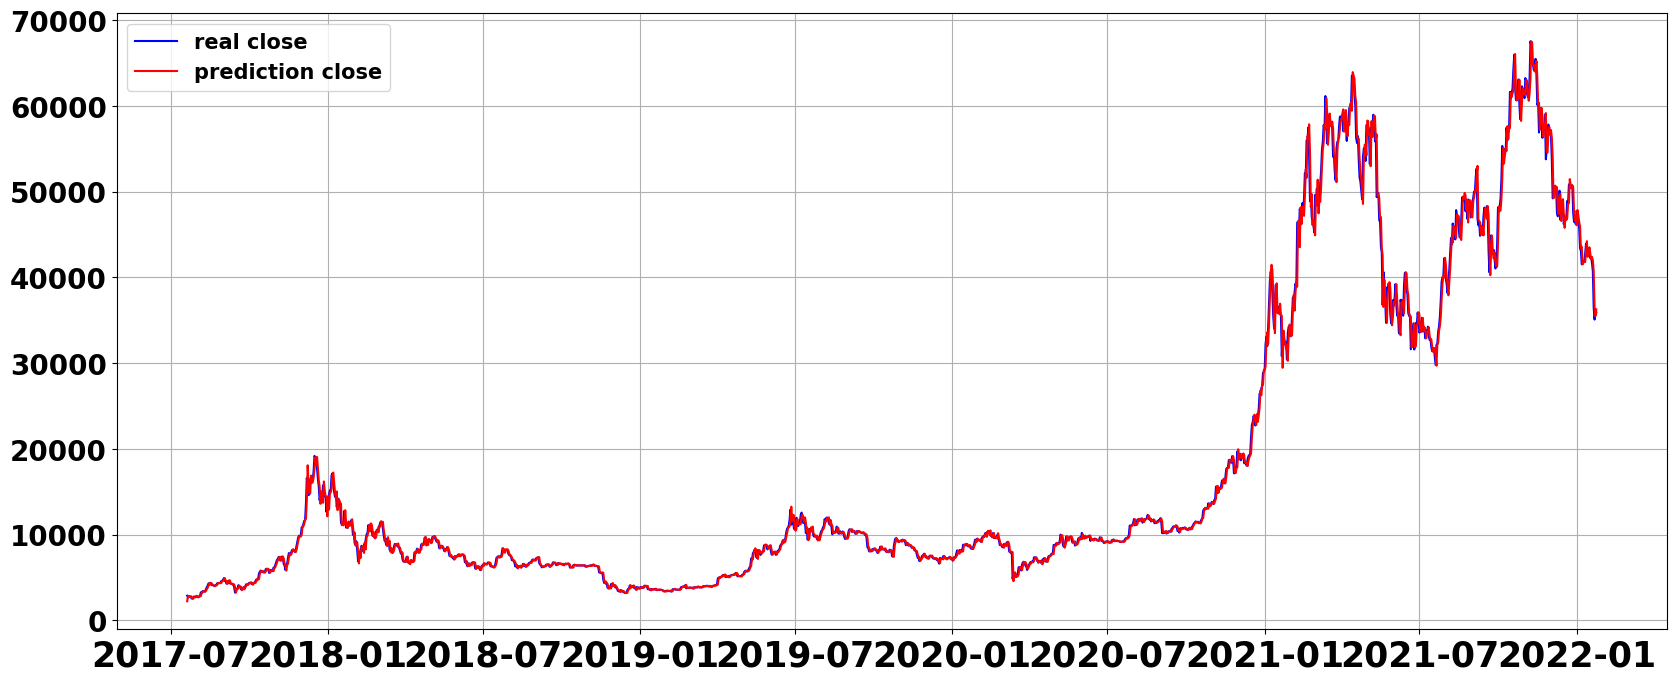

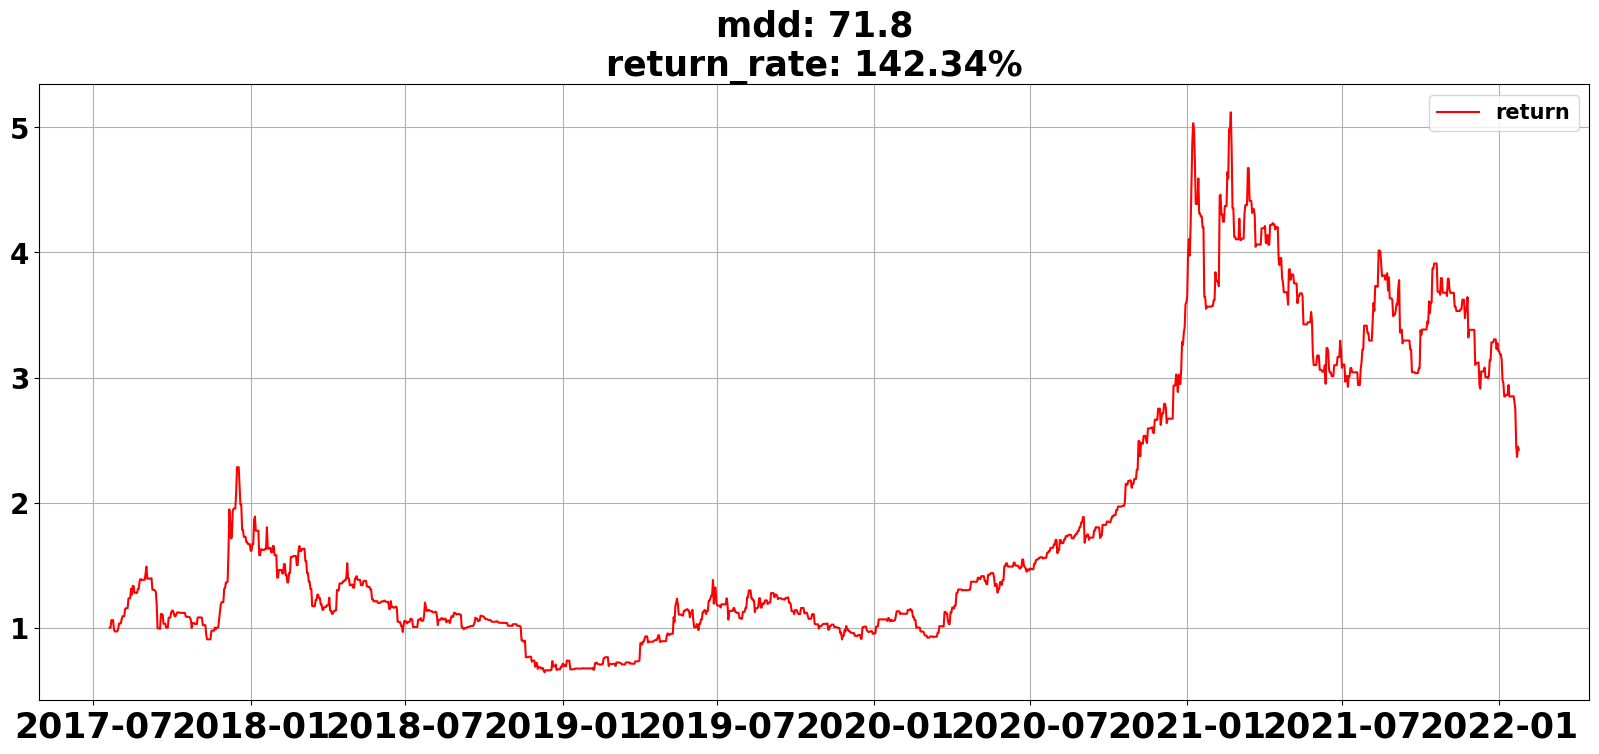

In [26]:
result_df = backtest_arima_1h(df, 100, 1)

In [30]:
result_df

,Open,High,Low,Close,Volume,Datetime,prediction_close,batch_open,trade,ror,cr,mdd,rate
2017-07-20,2265.21,2938.0,2265.21,2875.03,80333454.15,2017-07-20 00:00:00,2221.046457,2265.21,0,1,1,0.0,1
2017-07-21,2875.03,2887.45,2611.39,2670.0,56427932.93,2017-07-21 00:00:00,2833.41184,2875.03,0,1,1,0.0,1
2017-07-22,2670.0,2882.0,2644.59,2832.71,35783389.64,2017-07-22 00:00:00,2712.24606,2670.00,1,1.06094,1.06094,0.0,1
2017-07-23,2832.71,2855.0,2640.0,2749.02,30306854.43,2017-07-23 00:00:00,2817.012025,2832.71,0,1,1.06094,0.0,1
2017-07-24,2749.02,2800.0,2701.0,2759.98,27562683.88,2017-07-24 00:00:00,2725.503304,2749.02,0,1,1.06094,0.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-01-20,41733.21,43518.69,40554.14,40736.05,2425.152607,2022-01-20 00:00:00,42014.490042,41733.21,1,0.976106,2.736594,46.554774,1
2022-01-21,40654.72,41115.58,35423.0,36495.46,6201.046101,2022-01-21 00:00:00,40714.776052,40654.72,1,0.897693,2.456621,52.022592,1
2022-01-22,36447.37,36825.98,34000.0,35091.11,4510.372186,2022-01-22 00:00:00,36507.745763,36447.37,1,0.962789,2.365207,53.807901,1
2022-01-23,35084.79,36574.47,34624.59,36293.62,2533.703976,2022-01-23 00:00:00,35490.143911,35084.79,1,1.034455,2.446699,52.216374,1


In [35]:
temp_df = backtest_ma(result_df)[["ror", "cr", "mdd", "rate"]]

In [36]:
reuslt_df =

,ror,cr,mdd,rate
2017-07-20,1,1,0.0,0.0
2017-07-21,1,1,0.0,0.0
2017-07-22,1,1,0.0,0.0
2017-07-23,1,1,0.0,0.0
2017-07-24,1,1,0.0,0.2
...,...,...,...,...
2022-01-20,1,4.253511,27.657472,0.0
2022-01-21,1,4.253511,27.657472,0.0
2022-01-22,1,4.253511,27.657472,0.0
2022-01-23,1,4.253511,27.657472,0.0


In [ ]:
df["partition"] = ""
df["partition"] = np.where((df["Datetime"] >= "2021-05-10") & (df["Datetime"] <= "2021-07-21"), "loss1", df["partition"])
df["partition"] = np.where((df["Datetime"] >= "2021-11-18") & (df["Datetime"] <= "2022-02-06"), "loss2", df["partition"])
df["partition"] = np.where((df["Datetime"] >= "2019-02-17") & (df["Datetime"] <= "2019-07-15"), "profit1", df["partition"])
df["partition"] = np.where((df["Datetime"] >= "2020-10-08") & (df["Datetime"] <= "2021-04-17"), "profit2", df["partition"])



def get_result_loss_1(test_df):
    df = test_df.copy()
    df = df[(df.index >= "2021-05-10") & (df.index <= "2021-07-21")]
    df['ror'] = np.where(df['trade'] == 1, 1 + (df['Close'] / df['Open'] - 1) * df['rate'], 1)
    df['cr'] = df['ror'].cumprod()
    df['mdd'] = (df['cr'].cummax() - df['cr']) / df['cr'].cummax() * 100
    return analysis_return(df)


def get_result_loss_2(test_df):
    df = test_df.copy()
    df = df[(df.index >= "2021-11-18") & (df.index <= "2022-02-06")]
    df['ror'] = np.where(df['trade'] == 1, 1 + (df['Close'] / df['Open'] - 1) * df['rate'], 1)
    df['cr'] = df['ror'].cumprod()
    df['mdd'] = (df['cr'].cummax() - df['cr']) / df['cr'].cummax() * 100
    return analysis_return(df)


def get_result_profit_1(test_df):
    df = test_df.copy()
    df = df[(df.index >= "2019-02-17") & (df.index <= "2019-07-15")]
    df['ror'] = np.where(df['trade'] == 1, 1 + (df['Close'] / df['Open'] - 1) * df['rate'], 1)
    df['cr'] = df['ror'].cumprod()
    df['mdd'] = (df['cr'].cummax() - df['cr']) / df['cr'].cummax() * 100
    return analysis_return(df)


def get_result_profit_2(test_df):
    df = test_df.copy()
    df = df[(df.index >= "2020-10-08") & (df.index <= "2021-04-17")]
    df['ror'] = np.where(df['trade'] == 1, 1 + (df['Close'] / df['Open'] - 1) * df['rate'], 1)
    df['cr'] = df['ror'].cumprod()
    df['mdd'] = (df['cr'].cummax() - df['cr']) / df['cr'].cummax() * 100
    return analysis_return(df)

In [48]:
def create_csv_using_only_model(result_df, model_name):
    """
    100일 통합 결과

    Args:
        result_df: df - 백테스트 완료 테이블
        model_name: arima

    Returns:
        csv 파일
    """
    df = result_df.copy()

    df["partition"] = ""
    df["partition"] = np.where((df["Datetime"] >= datetime(year=2021, month=5, day=10)) & (df["Datetime"] <= datetime(year=2021, month=7, day=21)), "loss1", df["partition"])
    df["partition"] = np.where((df["Datetime"] >= datetime(year=2021, month=11, day=18)) & (df["Datetime"] <= datetime(year=2022, month=2, day=6)), "loss2", df["partition"])
    df["partition"] = np.where((df["Datetime"] >= datetime(year=2019, month=2, day=17)) & (df["Datetime"] <= datetime(year=2019, month=7, day=15)), "profit1", df["partition"])
    df["partition"] = np.where((df["Datetime"] >= datetime(year=2020, month=10, day=8)) & (df["Datetime"] <= datetime(year=2021, month=4, day=17)), "profit2", df["partition"])

    condition = "ma"
    temp_df = backtest_ma(df)[["ror", "cr", "mdd", "rate"]]
    df[f"{condition}+return_of_rate"] = temp_df["ror"]
    df[f"{condition}+cumulative_return_of_rate"] = temp_df["cr"]
    df[f"{condition}+mdd"] = temp_df["mdd"]
    df[f"{condition}+rate"] = temp_df["rate"]

    condition = "rsi"
    temp_df = backtest_rsi(df)[["ror", "cr", "mdd", "rate"]]
    df[f"{condition}+return_of_rate"] = temp_df["ror"]
    df[f"{condition}+cumulative_return_of_rate"] = temp_df["cr"]
    df[f"{condition}+mdd"] = temp_df["mdd"]
    df[f"{condition}+rate"] = temp_df["rate"]

    condition = "noise"
    temp_df = backtest_noise(df)[["ror", "cr", "mdd", "rate"]]
    df[f"{condition}+return_of_rate"] = temp_df["ror"]
    df[f"{condition}+cumulative_return_of_rate"] = temp_df["cr"]
    df[f"{condition}+mdd"] = temp_df["mdd"]
    df[f"{condition}+rate"] = temp_df["rate"]

    condition = "ma_noise"
    temp_df = backtest_ma_and_noise(df)[["ror", "cr", "mdd", "rate"]]
    df[f"{condition}+return_of_rate"] = temp_df["ror"]
    df[f"{condition}+cumulative_return_of_rate"] = temp_df["cr"]
    df[f"{condition}+mdd"] = temp_df["mdd"]
    df[f"{condition}+rate"] = temp_df["rate"]

    condition = "ma_rsi"
    temp_df = backtest_ma_and_rsi(df)[["ror", "cr", "mdd", "rate"]]
    df[f"{condition}+return_of_rate"] = temp_df["ror"]
    df[f"{condition}+cumulative_return_of_rate"] = temp_df["cr"]
    df[f"{condition}+mdd"] = temp_df["mdd"]
    df[f"{condition}+rate"] = temp_df["rate"]

    condition = "rsi_noise"
    temp_df = backtest_noise_and_rsi(df)[["ror", "cr", "mdd", "rate"]]
    df[f"{condition}+return_of_rate"] = temp_df["ror"]
    df[f"{condition}+cumulative_return_of_rate"] = temp_df["cr"]
    df[f"{condition}+mdd"] = temp_df["mdd"]
    df[f"{condition}+rate"] = temp_df["rate"]

    condition = "ma_rsi_noise"
    temp_df = backtest_ma_and_rsi_and_noise(df)[["ror", "cr", "mdd", "rate"]]
    df[f"{condition}+return_of_rate"] = temp_df["ror"]
    df[f"{condition}+cumulative_return_of_rate"] = temp_df["cr"]
    df[f"{condition}+mdd"] = temp_df["mdd"]
    df[f"{condition}+rate"] = temp_df["rate"]

    df.rename(columns={"ror": "return of rate", "cr": "cumulative return of rate"}, inplace=True)
    file_name = f"only_{model_name}.csv"
    df.to_csv(file_name)

    return df

def create_csv_using_only_best_model(result_df, model_name, fitting_term):
    """
    최고 성능 모델

    Args:
        result_df: df - 백테스트 완료 테이블
        model_name: arima
        fitting_term: 100 - 학습 일 수

    Returns:
        csv 파일
    """
    df = result_df.copy()
    df["partition"] = ""
    df["partition"] = np.where((df["Datetime"] >= datetime(year=2021, month=5, day=10)) & (df["Datetime"] <= datetime(year=2021, month=7, day=21)), "loss1", df["partition"])
    df["partition"] = np.where((df["Datetime"] >= datetime(year=2021, month=11, day=18)) & (df["Datetime"] <= datetime(year=2022, month=2, day=6)), "loss2", df["partition"])
    df["partition"] = np.where((df["Datetime"] >= datetime(year=2019, month=2, day=17)) & (df["Datetime"] <= datetime(year=2019, month=7, day=15)), "profit1", df["partition"])
    df["partition"] = np.where((df["Datetime"] >= datetime(year=2020, month=10, day=8)) & (df["Datetime"] <= datetime(year=2021, month=4, day=17)), "profit2", df["partition"])

    condition = "ma"
    temp_df = backtest_ma(df)[["ror", "cr", "mdd", "rate"]]
    df[f"{condition}+return_of_rate"] = temp_df["ror"]
    df[f"{condition}+cumulative_return_of_rate"] = temp_df["cr"]
    df[f"{condition}+mdd"] = temp_df["mdd"]
    df[f"{condition}+rate"] = temp_df["rate"]

    condition = "rsi"
    temp_df = backtest_rsi(df)[["ror", "cr", "mdd", "rate"]]
    df[f"{condition}+return_of_rate"] = temp_df["ror"]
    df[f"{condition}+cumulative_return_of_rate"] = temp_df["cr"]
    df[f"{condition}+mdd"] = temp_df["mdd"]
    df[f"{condition}+rate"] = temp_df["rate"]

    condition = "noise"
    temp_df = backtest_noise(df)[["ror", "cr", "mdd", "rate"]]
    df[f"{condition}+return_of_rate"] = temp_df["ror"]
    df[f"{condition}+cumulative_return_of_rate"] = temp_df["cr"]
    df[f"{condition}+mdd"] = temp_df["mdd"]
    df[f"{condition}+rate"] = temp_df["rate"]

    condition = "ma_noise"
    temp_df = backtest_ma_and_noise(df)[["ror", "cr", "mdd", "rate"]]
    df[f"{condition}+return_of_rate"] = temp_df["ror"]
    df[f"{condition}+cumulative_return_of_rate"] = temp_df["cr"]
    df[f"{condition}+mdd"] = temp_df["mdd"]
    df[f"{condition}+rate"] = temp_df["rate"]

    condition = "ma_rsi"
    temp_df = backtest_ma_and_rsi(df)[["ror", "cr", "mdd", "rate"]]
    df[f"{condition}+return_of_rate"] = temp_df["ror"]
    df[f"{condition}+cumulative_return_of_rate"] = temp_df["cr"]
    df[f"{condition}+mdd"] = temp_df["mdd"]
    df[f"{condition}+rate"] = temp_df["rate"]

    condition = "rsi_noise"
    temp_df = backtest_noise_and_rsi(df)[["ror", "cr", "mdd", "rate"]]
    df[f"{condition}+return_of_rate"] = temp_df["ror"]
    df[f"{condition}+cumulative_return_of_rate"] = temp_df["cr"]
    df[f"{condition}+mdd"] = temp_df["mdd"]
    df[f"{condition}+rate"] = temp_df["rate"]

    condition = "ma_rsi_noise"
    temp_df = backtest_ma_and_rsi_and_noise(df)[["ror", "cr", "mdd", "rate"]]
    df[f"{condition}+return_of_rate"] = temp_df["ror"]
    df[f"{condition}+cumulative_return_of_rate"] = temp_df["cr"]
    df[f"{condition}+mdd"] = temp_df["mdd"]
    df[f"{condition}+rate"] = temp_df["rate"]
    df.rename(columns={"ror": "return_of_rate", "cr": "cumulative_return_of_rate"}, inplace=True)

    file_name = f"only_best_{model_name}_{fitting_term}.csv"
    df.to_csv(file_name)
    return df


In [88]:
test_df = create_csv_using_only_best_model(result_df, "arima", 100)

In [120]:
test_df = create_csv_using_only_model(result_df, "arima")

In [70]:
test_df

,Open,High,Low,Close,Volume,Datetime,prediction_close,batch_open,trade,return_of_rate,...,ma_rsi+mdd,ma_rsi+rate,rsi_noise+return_of_rate,rsi_noise+cumulative_return_of_rate,rsi_noise+mdd,rsi_noise+rate,ma_rsi_noise+return_of_rate,ma_rsi_noise+cumulative_return_of_rate,ma_rsi_noise+mdd,ma_rsi_noise+rate
2017-07-20,2265.21,2938.0,2265.21,2875.03,80333454.15,2017-07-20 00:00:00,2221.046457,2265.21,0,1,...,0.0,0.0,1,1,0.0,0.0,1,1,0.0,0.0
2017-07-21,2875.03,2887.45,2611.39,2670.0,56427932.93,2017-07-21 00:00:00,2833.41184,2875.03,0,1,...,0.0,0.0,1,1,0.0,0.0,1,1,0.0,0.0
2017-07-22,2670.0,2882.0,2644.59,2832.71,35783389.64,2017-07-22 00:00:00,2712.24606,2670.00,1,1.06094,...,0.0,0.0,1,1,0.0,0.0,1,1,0.0,0.0
2017-07-23,2832.71,2855.0,2640.0,2749.02,30306854.43,2017-07-23 00:00:00,2817.012025,2832.71,0,1,...,0.0,0.0,1,1,0.0,0.0,1,1,0.0,0.0
2017-07-24,2749.02,2800.0,2701.0,2759.98,27562683.88,2017-07-24 00:00:00,2725.503304,2749.02,0,1,...,0.0,0.2,1,1,0.0,0.0,1,1,0.0,0.1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-01-20,41733.21,43518.69,40554.14,40736.05,2425.152607,2022-01-20 00:00:00,42014.490042,41733.21,1,0.976106,...,22.067774,0.0,1,2.055856,7.937952,0.2,1,3.321889,13.336859,0.1
2022-01-21,40654.72,41115.58,35423.0,36495.46,6201.046101,2022-01-21 00:00:00,40714.776052,40654.72,1,0.897693,...,22.067774,0.0,1,2.055856,7.937952,0.2,1,3.321889,13.336859,0.1
2022-01-22,36447.37,36825.98,34000.0,35091.11,4510.372186,2022-01-22 00:00:00,36507.745763,36447.37,1,0.962789,...,22.067774,0.0,1,2.055856,7.937952,0.2,1,3.321889,13.336859,0.1
2022-01-23,35084.79,36574.47,34624.59,36293.62,2533.703976,2022-01-23 00:00:00,35490.143911,35084.79,1,1.034455,...,22.067774,0.0,1,2.055856,7.937952,0.2,1,3.321889,13.336859,0.1


In [116]:
def get_extracted_df_from_total_df(test_df, condition_list=[], partition=None):
    """

    Args:
        test_df:
        condition_list: ["ma"], ["ma", "noise"], ["ma", "noise", "rsi"]
        partition: profit1, profit2, loss1, loss2

    Returns:
        df
    """
    condition = ""

    if len(condition_list) == 0:
        condition = ""

    elif len(condition_list) == 1:
        if "rsi" in condition_list:
            condition = "rsi"
        elif "ma" in condition_list:
            condition = "ma"
        elif "noise" in condition_list:
            condition = "noise"

    elif len(condition_list) == 2:
        if "rsi" in condition_list and "ma" in condition_list:
            condition = "ma_rsi"
        elif "rsi" in condition_list and "noise" in condition_list:
            condition = "rsi_noise"
        elif "noise" in condition_list and "ma" in condition_list:
            condition = "ma_noise"


    elif len(condition_list) == 3:
        condition = "ma_rsi_noise"


    if len(condition):
        columns = ["Datetime", "Close", "partition", "prediction_close", f"{condition}+return_of_rate", f"{condition}+cumulative_return_of_rate", f"{condition}+mdd", f"{condition}+rate" ]
    else:
        columns = ["Datetime", "Close", "partition", "prediction_close", "return_of_rate", "cumulative_return_of_rate", "mdd", "rate" ]

    df = test_df[columns]
    columns = list(map(lambda x:x.split("+")[-1], columns))
    df.columns = columns

    if partition == "profit1":
        df = df[df["partition"] == "profit1"]
    elif partition  == "profit2":
        df = df[df["partition"] == "profit2"]
    elif partition == "loss1":
        df = df[df["partition"] == "loss1"]
    elif partition == "loss2":
        df = df[df["partition"] == "loss2"]

    df['cumulative_return_of_rate'] = df['return_of_rate'].cumprod()
    df['mdd'] = (df['cumulative_return_of_rate'].cummax() - df['cumulative_return_of_rate']) / df['cumulative_return_of_rate'].cummax() * 100

    return df

In [117]:
example1_df = get_extracted_df_from_total_df(test_df=test_df, condition_list=[], partition=None)

In [113]:
example1_df = get_extracted_df_from_total_df(test_df=test_df, condition_list=["rsi"], partition="profit1")

In [104]:
example2_df = get_extracted_df_from_total_df(test_df=test_df, condition_list=["rsi"], partition="profit2")

In [105]:
example3_df = get_extracted_df_from_total_df(test_df=test_df, condition_list=["rsi"], partition="loss1")

In [106]:
example4_df = get_extracted_df_from_total_df(test_df=test_df, condition_list=["rsi"], partition="loss2")

In [118]:
example1_df

,Datetime,Close,partition,prediction_close,return_of_rate,cumulative_return_of_rate,mdd,rate
2017-07-20,2017-07-20 00:00:00,2875.03,,2221.046457,1,1,0.0,1
2017-07-21,2017-07-21 00:00:00,2670.0,,2833.41184,1,1,0.0,1
2017-07-22,2017-07-22 00:00:00,2832.71,,2712.24606,1.06094,1.06094,0.0,1
2017-07-23,2017-07-23 00:00:00,2749.02,,2817.012025,1,1.06094,0.0,1
2017-07-24,2017-07-24 00:00:00,2759.98,,2725.503304,1,1.06094,0.0,1
...,...,...,...,...,...,...,...,...
2022-01-20,2022-01-20 00:00:00,40736.05,loss2,42014.490042,0.976106,2.736594,46.554774,1
2022-01-21,2022-01-21 00:00:00,36495.46,loss2,40714.776052,0.897693,2.456621,52.022592,1
2022-01-22,2022-01-22 00:00:00,35091.11,loss2,36507.745763,0.962789,2.365207,53.807901,1
2022-01-23,2022-01-23 00:00:00,36293.62,loss2,35490.143911,1.034455,2.446699,52.216374,1


In [108]:
example2_df

,Datetime,Close,partition,prediction_close,return_of_rate,cumulative_return_of_rate,mdd,rate
2020-10-08,2020-10-08 00:00:00,10925.2,profit2,10641.927043,1,1,0.0,1
2020-10-09,2020-10-09 00:00:00,11052.0,profit2,10920.300901,1,1,0.0,1
2020-10-10,2020-10-10 00:00:00,11301.2,profit2,11113.714239,1.021766,1.021766,0.0,1
2020-10-11,2020-10-11 00:00:00,11372.93,profit2,11279.425492,1,1.021766,0.0,1
2020-10-12,2020-10-12 00:00:00,11535.98,profit2,11433.778967,1.014377,1.036456,0.0,1
...,...,...,...,...,...,...,...,...
2021-04-13,2021-04-13 00:00:00,63564.48,profit2,59453.049799,1,2.267868,17.674041,1
2021-04-14,2021-04-14 00:00:00,62986.09,profit2,63958.077056,0.990259,2.245776,18.476,1
2021-04-15,2021-04-15 00:00:00,63239.19,profit2,63564.003988,1.004527,2.255943,18.106946,1
2021-04-16,2021-04-16 00:00:00,61436.24,profit2,63194.210947,1,2.255943,18.106946,1


In [109]:
example3_df

,Datetime,Close,partition,prediction_close,return_of_rate,cumulative_return_of_rate,mdd,rate
2021-05-10,2021-05-10 00:00:00,55880.72,loss1,58796.061865,0.957909,0.957909,0.0,1
2021-05-11,2021-05-11 00:00:00,56763.7,loss1,56115.568079,1.016279,0.973503,0.0,1
2021-05-12,2021-05-12 00:00:00,49386.56,loss1,56687.661529,1,0.973503,0.0,1
2021-05-13,2021-05-13 00:00:00,49694.96,loss1,49541.335049,1.005575,0.97893,0.0,1
2021-05-14,2021-05-14 00:00:00,49880.43,loss1,49676.567301,1,0.97893,0.0,1
...,...,...,...,...,...,...,...,...
2021-07-17,2021-07-17 00:00:00,31529.68,loss1,31335.288762,1,0.900588,10.136674,1
2021-07-18,2021-07-18 00:00:00,31776.65,loss1,31421.754548,1,0.900588,10.136674,1
2021-07-19,2021-07-19 00:00:00,30829.29,loss1,31719.636743,1,0.900588,10.136674,1
2021-07-20,2021-07-20 00:00:00,29786.58,loss1,30825.728223,1,0.900588,10.136674,1


In [110]:
example4_df

,Datetime,Close,partition,prediction_close,return_of_rate,cumulative_return_of_rate,mdd,rate
2021-11-18,2021-11-18 00:00:00,56917.66,loss2,60372.422928,1,1,0.0,1
2021-11-19,2021-11-19 00:00:00,58128.55,loss2,57238.40623,1,1,0.0,1
2021-11-20,2021-11-20 00:00:00,59768.54,loss2,58066.436186,1,1,0.0,1
2021-11-21,2021-11-21 00:00:00,58678.47,loss2,59781.141658,1,1,0.0,1
2021-11-22,2021-11-22 00:00:00,56294.11,loss2,58691.583048,1,1,0.0,1
...,...,...,...,...,...,...,...,...
2022-01-20,2022-01-20 00:00:00,40736.05,loss2,42014.490042,1,0.920127,7.987267,1
2022-01-21,2022-01-21 00:00:00,36495.46,loss2,40714.776052,1,0.920127,7.987267,1
2022-01-22,2022-01-22 00:00:00,35091.11,loss2,36507.745763,1,0.920127,7.987267,1
2022-01-23,2022-01-23 00:00:00,36293.62,loss2,35490.143911,1,0.920127,7.987267,1


In [27]:
result_df = backtest_ma(result_df)
print(get_result_loss_1(result_df))
print(get_result_loss_2(result_df))
print(get_result_profit_1(result_df))
print(get_result_profit_2(result_df))

{'trade_rate': ' 20.55%', 'success_rate': ' 33.33%', 'pnl_rate': ' 0.21', 'mdd': ' 12.27%', 'cr': '-15.01%'}
{'trade_rate': ' 28.40%', 'success_rate': ' 56.52%', 'pnl_rate': ' 0.58', 'mdd': ' 6.68%', 'cr': '-4.89%'}
{'trade_rate': ' 57.05%', 'success_rate': ' 61.18%', 'pnl_rate': ' 1.51', 'mdd': ' 18.93%', 'cr': ' 49.33%'}
{'trade_rate': ' 56.25%', 'success_rate': ' 57.41%', 'pnl_rate': ' 1.88', 'mdd': ' 19.76%', 'cr': ' 136.64%'}


In [28]:
result_df = backtest_rsi(result_df)
print(get_result_loss_1(result_df))
print(get_result_loss_2(result_df))
print(get_result_profit_1(result_df))
print(get_result_profit_2(result_df))

{'trade_rate': ' 26.03%', 'success_rate': ' 10.53%', 'pnl_rate': ' 0.11', 'mdd': ' 10.33%', 'cr': '-12.67%'}
{'trade_rate': ' 14.81%', 'success_rate': ' 16.67%', 'pnl_rate': ' 5.31', 'mdd': ' 0.42%', 'cr': ' 1.85%'}
{'trade_rate': ' 55.03%', 'success_rate': ' 60.98%', 'pnl_rate': ' 1.48', 'mdd': ' 18.93%', 'cr': ' 44.18%'}
{'trade_rate': ' 53.65%', 'success_rate': ' 58.25%', 'pnl_rate': ' 1.89', 'mdd': ' 18.91%', 'cr': ' 138.40%'}


In [29]:
result_df = backtest_noise(result_df)
print(get_result_loss_1(result_df))
print(get_result_loss_2(result_df))
print(get_result_profit_1(result_df))
print(get_result_profit_2(result_df))

{'trade_rate': ' 45.21%', 'success_rate': ' 42.42%', 'pnl_rate': ' 0.65', 'mdd': ' 6.95%', 'cr': '-7.52%'}
{'trade_rate': ' 56.79%', 'success_rate': ' 47.83%', 'pnl_rate': ' 0.57', 'mdd': ' 11.66%', 'cr': '-10.01%'}
{'trade_rate': ' 57.05%', 'success_rate': ' 61.18%', 'pnl_rate': ' 1.36', 'mdd': ' 11.82%', 'cr': ' 15.42%'}
{'trade_rate': ' 56.25%', 'success_rate': ' 57.41%', 'pnl_rate': ' 1.70', 'mdd': ' 12.68%', 'cr': ' 33.43%'}


In [30]:
result_df = backtest_ma_and_rsi(result_df)
print(get_result_loss_1(result_df))
print(get_result_loss_2(result_df))
print(get_result_profit_1(result_df))
print(get_result_profit_2(result_df))

{'trade_rate': ' 12.33%', 'success_rate': ' 22.22%', 'pnl_rate': ' 0.11', 'mdd': ' 10.33%', 'cr': '-12.67%'}
{'trade_rate': ' 6.17%', 'success_rate': ' 40.00%', 'pnl_rate': ' 5.31', 'mdd': ' 0.42%', 'cr': ' 1.85%'}
{'trade_rate': ' 55.03%', 'success_rate': ' 60.98%', 'pnl_rate': ' 1.48', 'mdd': ' 18.93%', 'cr': ' 44.18%'}
{'trade_rate': ' 53.65%', 'success_rate': ' 58.25%', 'pnl_rate': ' 1.89', 'mdd': ' 18.91%', 'cr': ' 138.40%'}


In [31]:
result_df = backtest_ma_and_noise(result_df)
print(get_result_loss_1(result_df))
print(get_result_loss_2(result_df))
print(get_result_profit_1(result_df))
print(get_result_profit_2(result_df))

{'trade_rate': ' 45.21%', 'success_rate': ' 42.42%', 'pnl_rate': ' 0.44', 'mdd': ' 9.39%', 'cr': '-11.29%'}
{'trade_rate': ' 56.79%', 'success_rate': ' 47.83%', 'pnl_rate': ' 0.57', 'mdd': ' 8.21%', 'cr': '-7.44%'}
{'trade_rate': ' 57.05%', 'success_rate': ' 61.18%', 'pnl_rate': ' 1.46', 'mdd': ' 14.95%', 'cr': ' 32.38%'}
{'trade_rate': ' 56.25%', 'success_rate': ' 57.41%', 'pnl_rate': ' 1.83', 'mdd': ' 16.25%', 'cr': ' 79.38%'}


In [32]:
result_df = backtest_noise_and_rsi(result_df)
print(get_result_loss_1(result_df))
print(get_result_loss_2(result_df))
print(get_result_profit_1(result_df))
print(get_result_profit_2(result_df))

{'trade_rate': ' 26.03%', 'success_rate': ' 42.11%', 'pnl_rate': ' 0.79', 'mdd': ' 5.56%', 'cr': '-2.50%'}
{'trade_rate': ' 14.81%', 'success_rate': ' 33.33%', 'pnl_rate': ' 0.50', 'mdd': ' 3.44%', 'cr': '-2.68%'}
{'trade_rate': ' 55.03%', 'success_rate': ' 60.98%', 'pnl_rate': ' 1.28', 'mdd': ' 11.82%', 'cr': ' 11.74%'}
{'trade_rate': ' 53.65%', 'success_rate': ' 58.25%', 'pnl_rate': ' 1.74', 'mdd': ' 11.74%', 'cr': ' 34.51%'}


In [33]:
result_df = backtest_ma_and_rsi_and_noise(result_df)
print(get_result_loss_1(result_df))
print(get_result_loss_2(result_df))
print(get_result_profit_1(result_df))
print(get_result_profit_2(result_df))

{'trade_rate': ' 26.03%', 'success_rate': ' 42.11%', 'pnl_rate': ' 0.40', 'mdd': ' 6.63%', 'cr': '-7.69%'}
{'trade_rate': ' 14.81%', 'success_rate': ' 33.33%', 'pnl_rate': ' 0.86', 'mdd': ' 1.72%', 'cr': '-0.43%'}
{'trade_rate': ' 55.03%', 'success_rate': ' 60.98%', 'pnl_rate': ' 1.41', 'mdd': ' 14.95%', 'cr': ' 27.98%'}
{'trade_rate': ' 53.65%', 'success_rate': ' 58.25%', 'pnl_rate': ' 1.85', 'mdd': ' 15.36%', 'cr': ' 80.77%'}


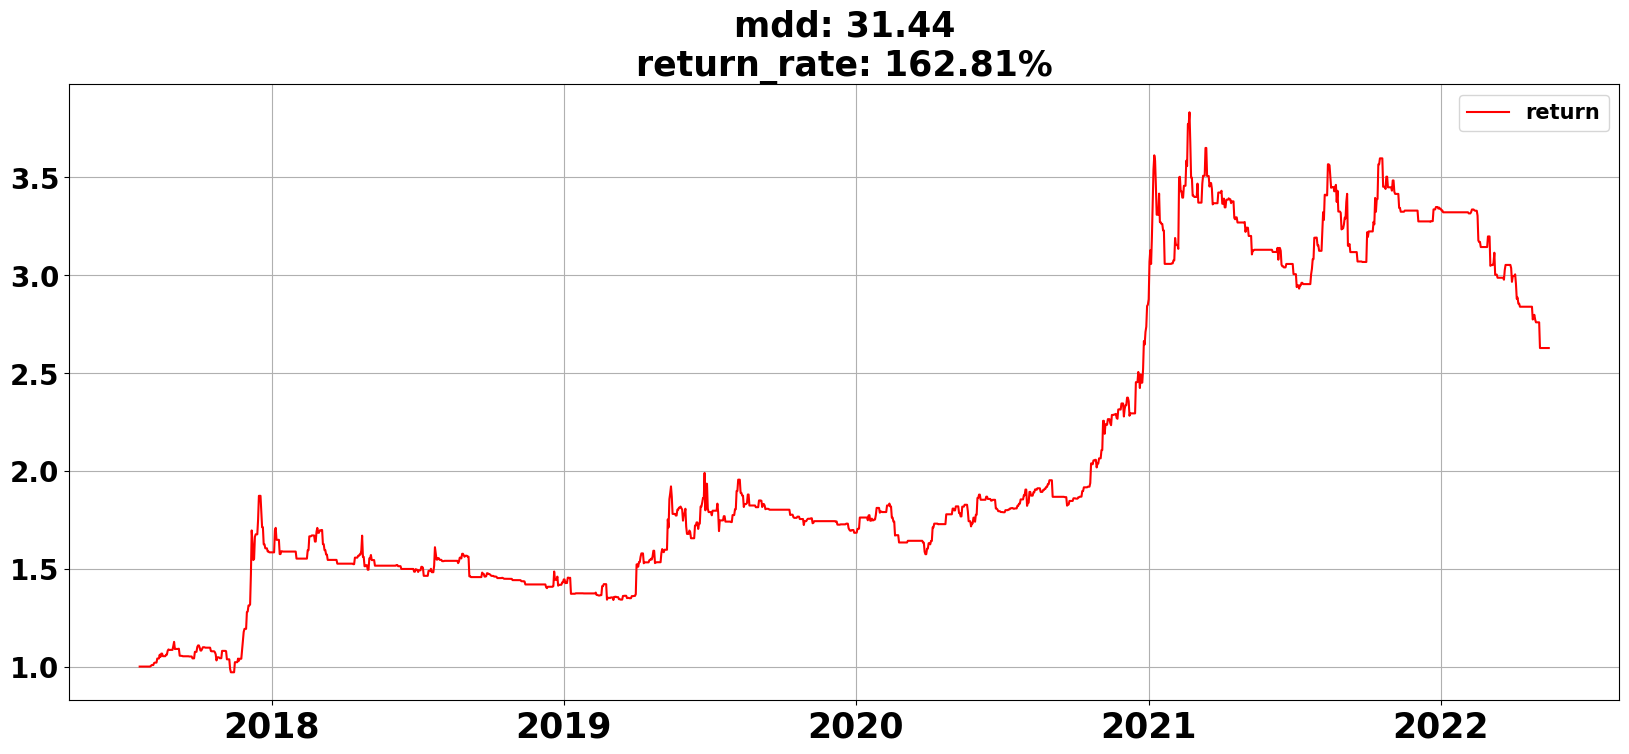

{'trade_rate': ' 37.34%',
 'success_rate': ' 51.98%',
 'pnl_rate': ' 1.25',
 'mdd': ' 31.44%',
 'cr': ' 162.81%'}

In [22]:
result_df = backtest_ma_and_rsi_and_noise(result_df)
plot_return(result_df)
analysis_return(result_df)

2214it [05:59,  6.15it/s]


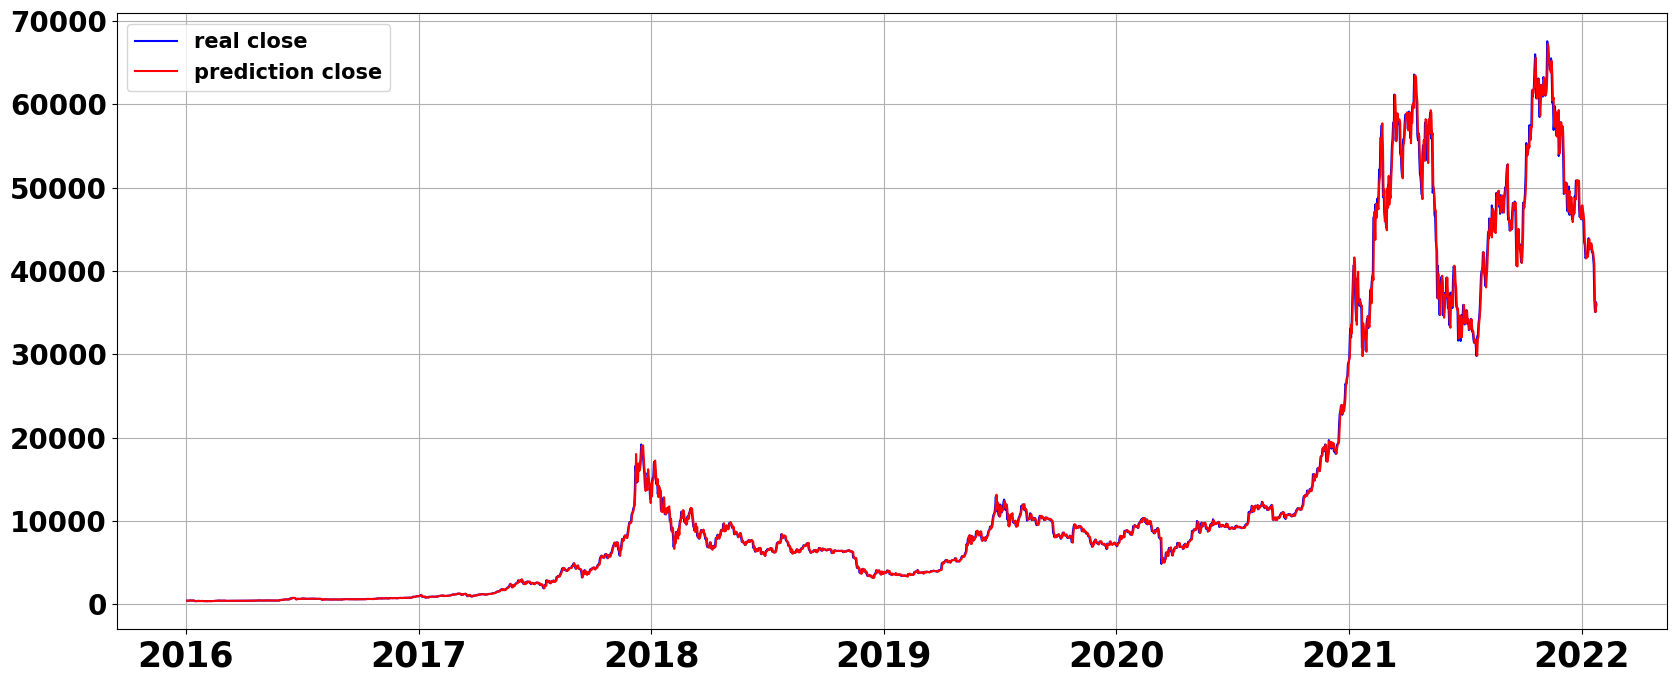

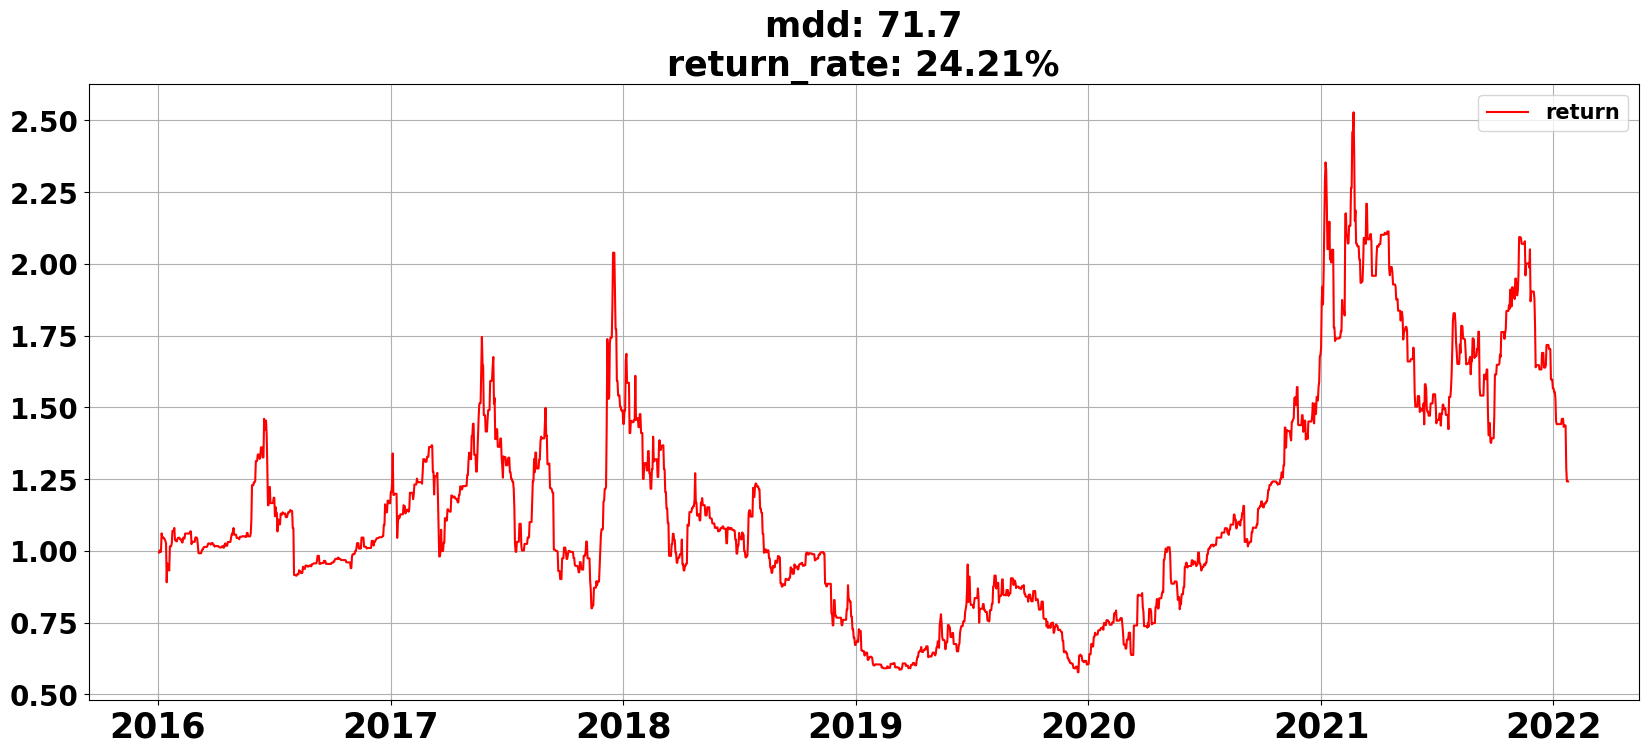

In [54]:
result_df_2 = backtest_arima_1h(df, 300, 1)

503it [00:56,  8.86it/s]


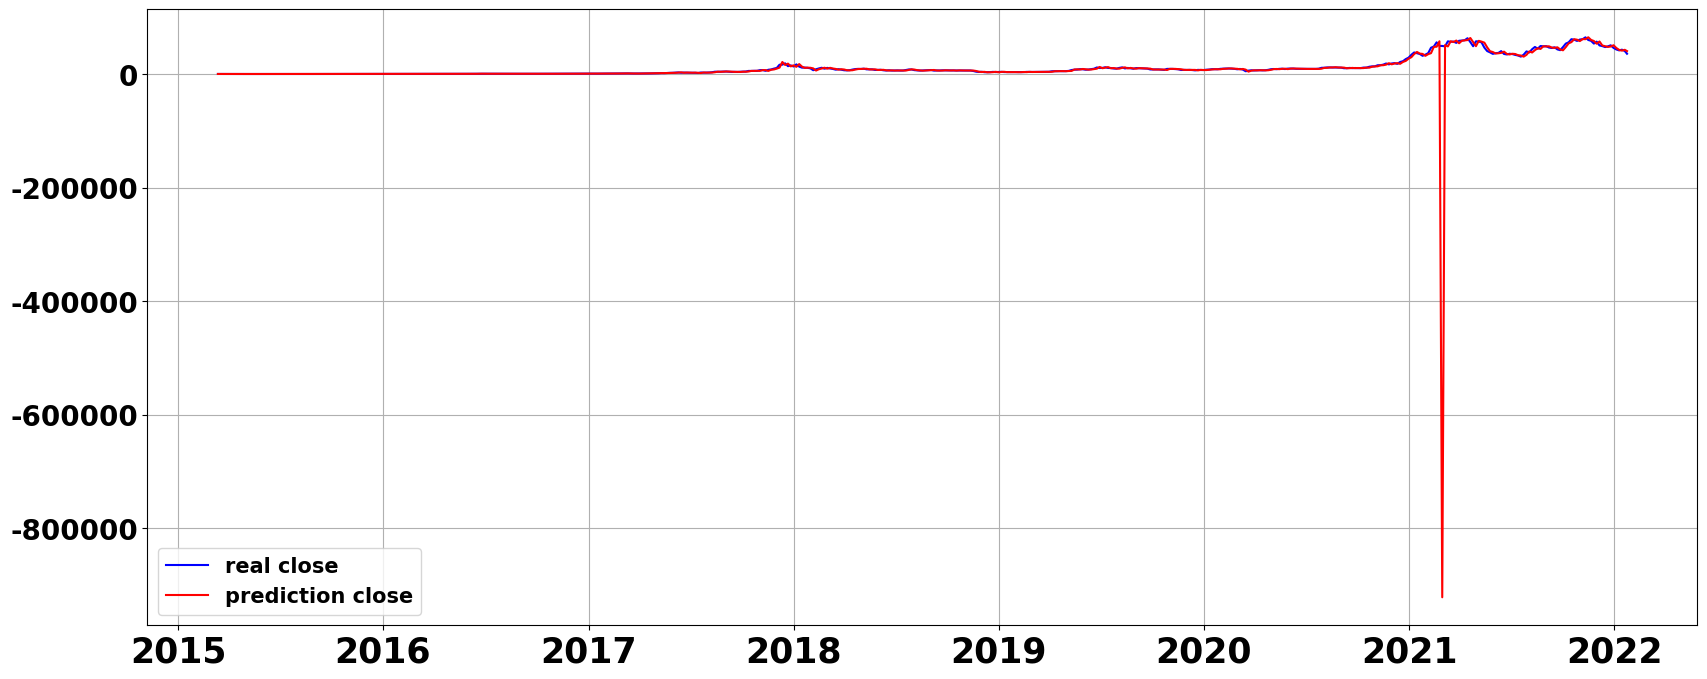

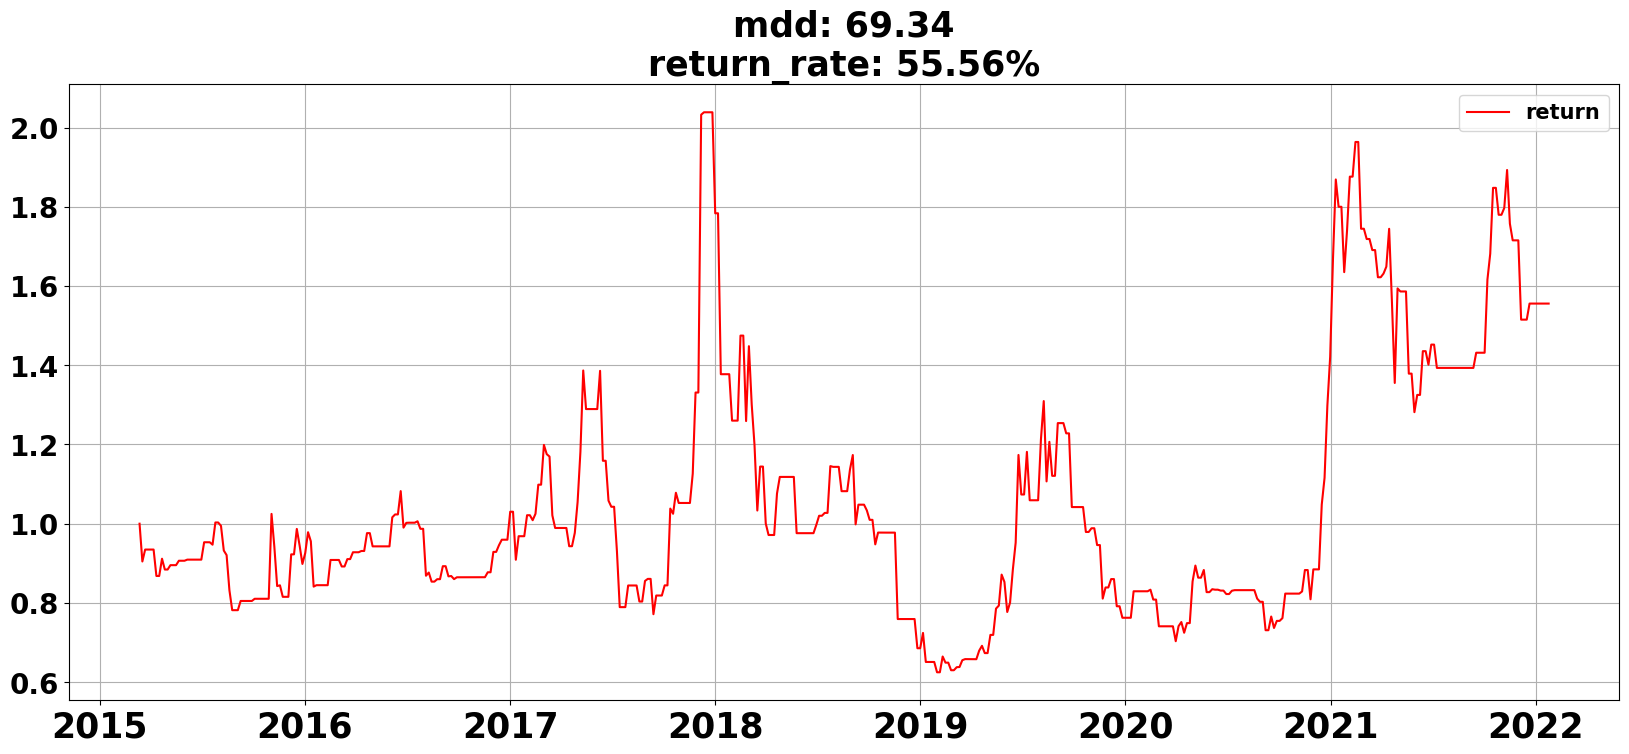

In [52]:
result_df_3 = backtest_arima_1h(df, 100, 5)

483it [01:02,  7.72it/s]


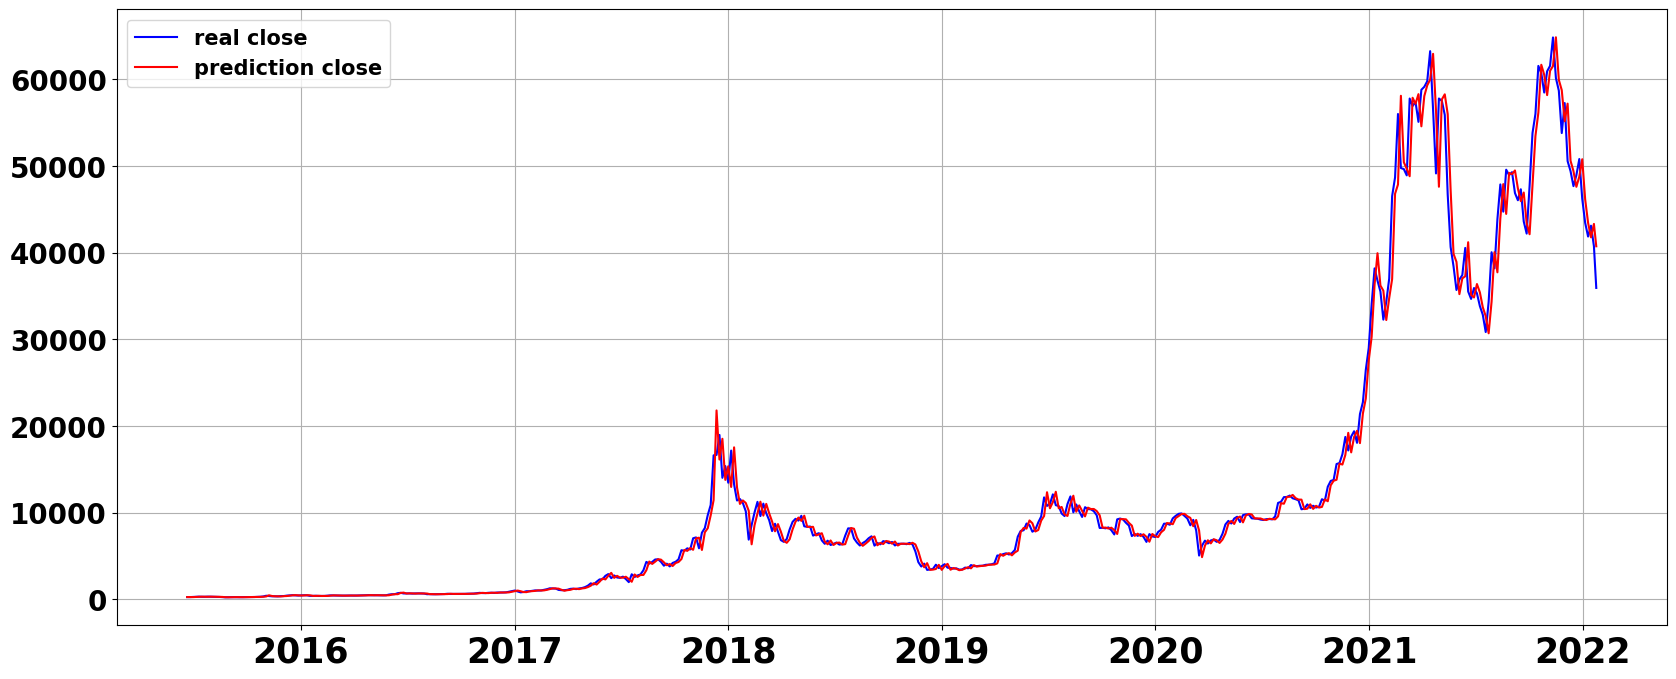

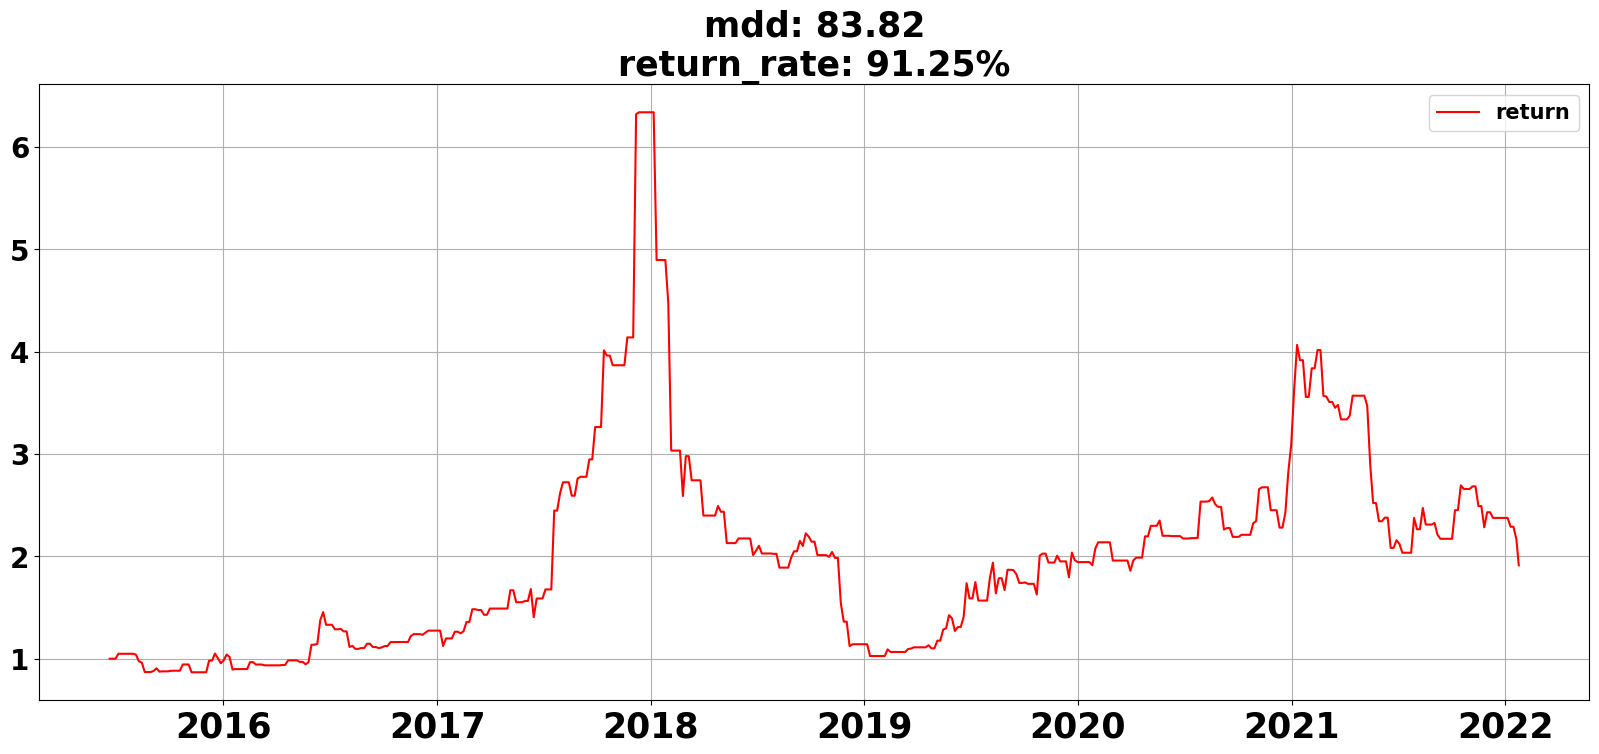

In [53]:
result_df_4 = backtest_arima_1h(df, 200, 5)

In [18]:
analysis_return(result_df)

{'trade_rate': ' 51.58%',
 'success_rate': ' 54.27%',
 'pnl_rate': ' 1.11',
 'mdd': ' 62.15%',
 'cr': ' 79.51%'}

In [ ]:
result_df = backtest_arima_1h(df, 50, 24)

In [34]:
from sklearn.preprocessing import MinMaxScaler

In [33]:
from sklearn.metrics import mean_squared_error
y=result_df['Close']
y_pred=result_df['prediction_close']
RMSE = mean_squared_error(y, y_pred)**0.5
print(RMSE)

838.5482589577512


In [40]:
min_max_scaler = MinMaxScaler()
result_df_s = min_max_scaler.fit_transform(result_df[['Close', 'prediction_close']])
# result_df['prediction_close_s'] = min_max_scaler.fit_transform(list(result_df['prediction_close']))

In [41]:
result_df_s.rename()

array([[5.04697967e-04, 5.28081486e-04],
       [5.38997829e-04, 4.56530135e-04],
       [4.69655684e-04, 5.53205469e-04],
       ...,
       [5.17902969e-01, 5.39031129e-01],
       [5.35758348e-01, 5.23918208e-01],
       [5.30172668e-01, 5.35701598e-01]])

In [43]:
y=result_df_s[0]
y_pred=result_df_s[1]
RMSE = mean_squared_error(y, y_pred)**0.5
print(RMSE)

5.6107381144874705e-05


In [47]:
5.6107 ** (-5)


0.00017985178828473094